/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/utils/docs.py:830: DeprecationWarning: Function read_montage is deprecated; ``read_montage`` is deprecated and will be removed in v0.20. Please use ``read_dig_fif``, ``read_dig_egi``, ``read_custom_montage``, or ``read_dig_captrack`` to read a digitization based on your needs instead; or ``make_standard_montage`` to create ``DigMontage`` based on template; or ``make_dig_montage`` to create a ``DigMontage`` out of np.arrays
  warnings.warn(msg, category=DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/mne/utils/docs.py:813: DeprecationWarning: Class Montage is deprecated; Montage class is deprecated and will be removed in v0.20. Please use DigMontage instead.
  warnings.warn(msg, category=DeprecationWarning)
<ipython-input-3-c6c11bab5267>:137: DeprecationWarning: Setting a montage using anything rather than DigMontage is deprecated and will raise an error in

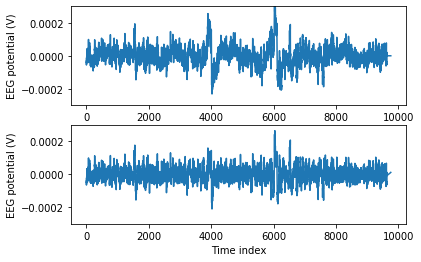

In [3]:
import numpy as np
import mne
import scipy
import logging
import matplotlib.pyplot as plt

def removeTrend(
    EEG,
    detrendType="High pass",
    sample_rate=160.0,
    detrendCutoff=1.0,
    detrendChannels=None,
):

    """Performs high pass filtering or detrending.
    Parameters
    __________
    EEG: np.ndarray
         The input EEG data.
    detrendType: str
                 Type of detrending to be performed: high pass, high pass sinc, or local detrending.
    sample_rate: float
                 Rate at which the EEG data was sampled.
    detrendCutoff: float
                   High pass cut-off frequency.
    detrendChannels: list
                     List of all the channels that require detrending/filtering (default: All channels).
    Returns
    ______
    EEG: np.ndarray
         Filtered/detrended EEG data.
    Notes
    _____
    Filtering is implemented using the MNE filter function mne.filter.filter_data.
    Local detrending is the python implementation of the chronux_2 runline command.
    """
    if len(EEG.shape) == 1:
        EEG = np.reshape(EEG, (1, EEG.shape[0]))

    if detrendType == "High pass":
        EEG = mne.filter.filter_data(
            EEG, sfreq=sample_rate, l_freq=1, h_freq=None, picks=detrendChannels
        )

    elif detrendType == "High pass sinc":
        fOrder = np.round(14080 * sample_rate / 512)
        fOrder = np.int(fOrder + fOrder % 2)
        EEG = mne.filter.filter_data(
            data=EEG,
            sfreq=sample_rate,
            l_freq=1,
            h_freq=None,
            picks=detrendChannels,
            filter_length=fOrder,
            fir_window="blackman",
        )
    elif detrendType == "Local detrend":
        if detrendChannels == None:
            detrendChannels = np.arange(0, EEG.shape[0])
        windowSize = 1.5 / detrendCutoff
        windowSize = np.minimum(windowSize, EEG.shape[1])
        stepSize = 0.02
        EEG = np.transpose(EEG)
        n = np.round(sample_rate * windowSize)
        dn = np.round(sample_rate * stepSize)

        if dn > n or dn < 1:
            logging.error(
                "Step size should be less than the window size and contain at least 1 sample"
            )
        if n == EEG.shape[0]:
            data = scipy.signal.detrend(EEG, axis=0)
        else:
            for ch in detrendChannels:
                EEG[:, ch] = runline(EEG[:, ch], np.int(n), np.int(dn))
        EEG = np.transpose(EEG)
    else:
        logging.warning(
            "No filtering/detreding performed since the detrend type did not match"
        )
    return EEG


def runline(y, n, dn):
    """ Python implementation of chronux_2 runline command for performing local linear regression.
    Parameters
    __________
    y: np.ndarray
       Input from one EEG channel.
    n: int
        length of the detrending window.
    dn: int
        length of the window step size.

    Returns
    _______
    y: np.ndarray
       Detrended EEG signal for one channel.
    """
    nt = y.shape[0]
    y_line = np.zeros((nt, 1))
    norm = np.zeros((nt, 1))
    nwin = np.int(np.ceil((nt - n) / dn))
    yfit = np.zeros((nwin, n))
    xwt = (np.arange(1, n + 1) - n / 2) / (n / 2)
    wt = np.power(1 - np.power(np.absolute(xwt), 3), 3)
    for j in range(0, nwin):
        tseg = y[dn * j : dn * j + n]
        y1 = np.mean(tseg)
        y2 = np.mean(np.multiply(np.arange(1, n + 1), tseg)) * (2 / (n + 1))
        a = np.multiply(np.subtract(y2, y1), 6 / (n - 1))
        b = np.subtract(y1, a * (n + 1) / 2)
        yfit[j, :] = np.multiply(np.arange(1, n + 1), a) + b
        y_line[j * dn : j * dn + n] = y_line[j * dn : j * dn + n] + np.reshape(
            np.multiply(yfit[j, :], wt), (n, 1)
        )
        norm[j * dn : j * dn + n] = norm[j * dn : j * dn + n] + np.reshape(wt, (n, 1))

    for i in range(0, len(norm)):
        if norm[i] > 0:
            y_line[i] = y_line[i] / norm[i]
    indx = (nwin - 1) * dn + n - 1
    npts = len(y) - indx + 1
    y_line[indx - 1 :] = np.reshape(
        (np.multiply(np.arange(n + 1, n + npts + 1), a) + b), (npts, 1)
    )
    for i in range(0, len(y_line)):
        y[i] = y[i] - y_line[i]
    return y

# raw = mne.io.read_raw_edf("C:\\Users\\Aamna\\Desktop\\NDD\\S001R04.edf", preload=True)
raw = mne.io.read_raw_edf('../tests/test_data/S001R01.edf', preload=True)

raw.rename_channels(lambda s: s.strip("."))
a=mne.channels.read_montage(kind='standard_1020',ch_names=raw.info['ch_names'])
mne.set_log_level("WARNING")
raw.set_montage(a)
eeg=raw.get_data()
plt.subplot(211)
plt.plot(eeg[0,:])
plt.ylim(-0.0003,0.0003)
plt.xlabel('Time index')
plt.ylabel('EEG potential (V)')
eeg=removeTrend(eeg,detrendType='Local detrend',sample_rate=160,detrendChannels=[0])
plt.subplot(212)
plt.plot(eeg[0,:])
plt.ylim(-0.0003,0.0003)
plt.xlabel('Time index')
plt.ylabel('EEG potential (V)')
plt.show()

